In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from pylab import rcParams
from math import sqrt
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
airlines_data = pd.read_excel("Airlines+Data.xlsx")
airlines_data

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


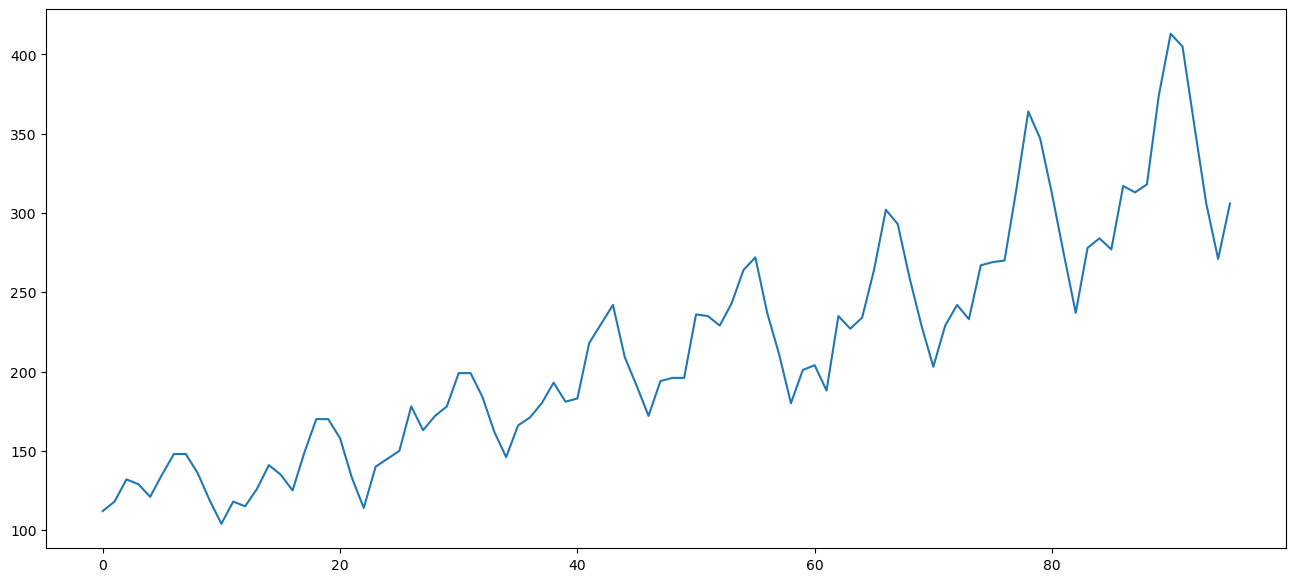

In [3]:
#Lineplot

airlines_data['Passengers'].plot(figsize=(16,7));

The data has a trend and stationarity has to be checked.

## Moving Average

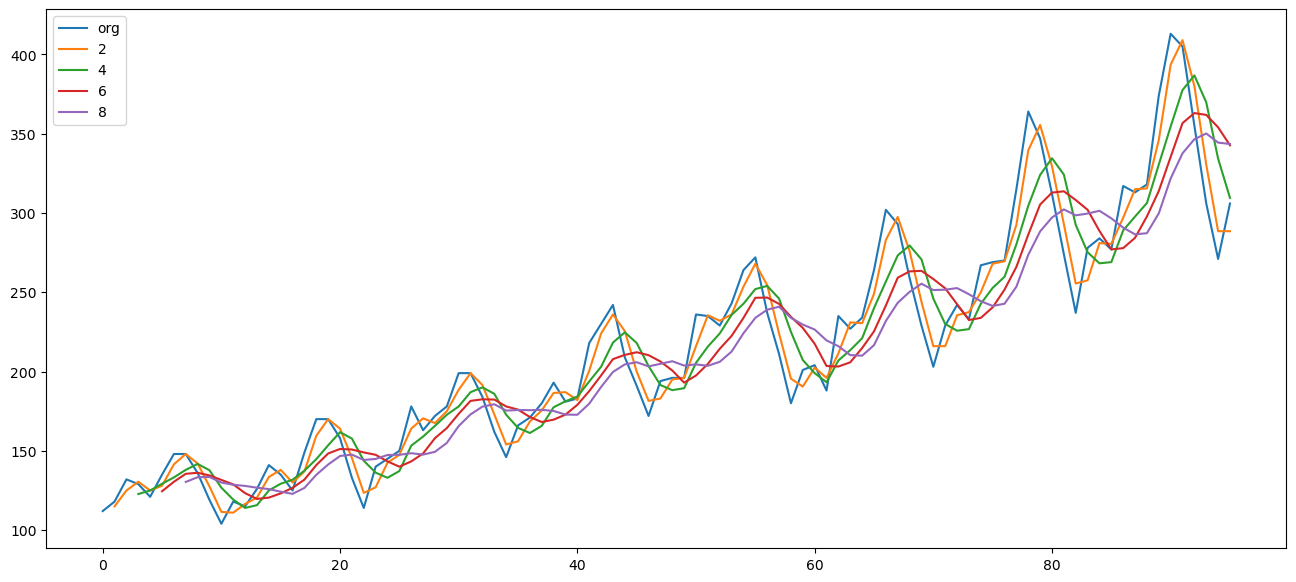

In [4]:
plt.figure(figsize=(16,7))
airlines_data.Passengers.plot(label="org")
for i in range(2,10,2):
    airlines_data['Passengers'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best');

In [5]:
airlines_data = airlines_data.set_index('Month')
airlines_data['SMA_2'] = airlines_data['Passengers'].rolling(2, min_periods=1).mean()
airlines_data['SMA_4'] = airlines_data['Passengers'].rolling(4, min_periods=1).mean()
airlines_data['SMA_6'] = airlines_data['Passengers'].rolling(6, min_periods=1).mean()

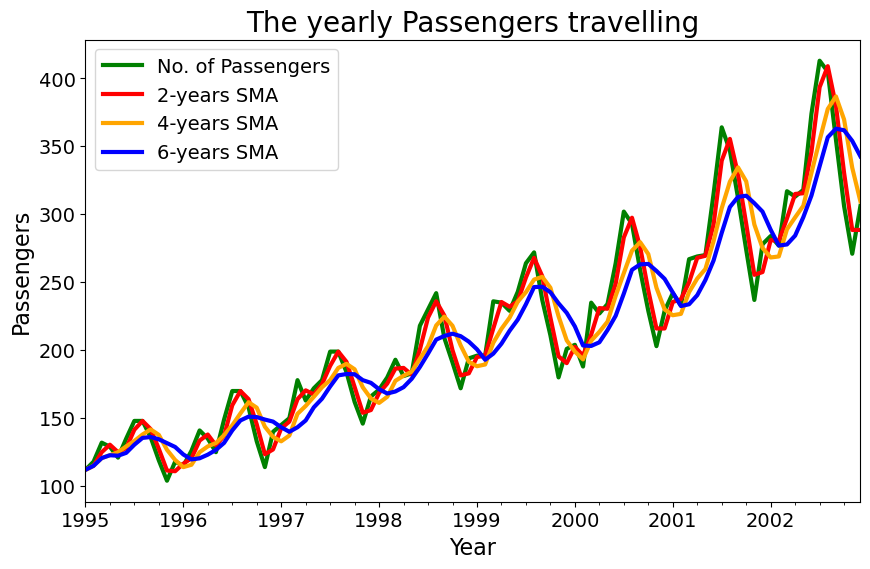

In [6]:
colors = ['green', 'red', 'orange','blue']
airlines_data.plot(color=colors, linewidth=3, figsize=(10,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['No. of Passengers', '2-years SMA', '4-years SMA','6-years SMA'], fontsize=14)
plt.title('The yearly Passengers travelling', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Passengers', fontsize=16);

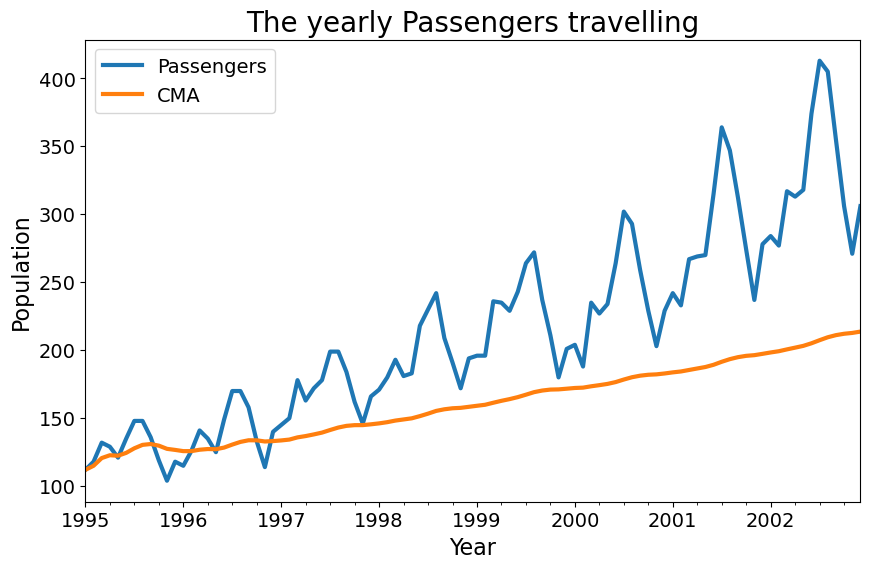

In [7]:
#Cumulative Moving Average
airlines_data['CMA'] = airlines_data['Passengers'].expanding().mean()
airlines_data[['Passengers', 'CMA']].plot( linewidth=3, figsize=(10,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Passengers', 'CMA'], fontsize=14)
plt.title('The yearly Passengers travelling', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Population', fontsize=16);

In [8]:
 #Exponential Moving Average with a smoothing factor (alpha) 

In [9]:
airlines_data['Ema_0.1'] = airlines_data['Passengers'].ewm(alpha=0.1,adjust=False).mean()
airlines_data['Ema_0.3'] = airlines_data['Passengers'].ewm(alpha=0.3,adjust=False).mean()

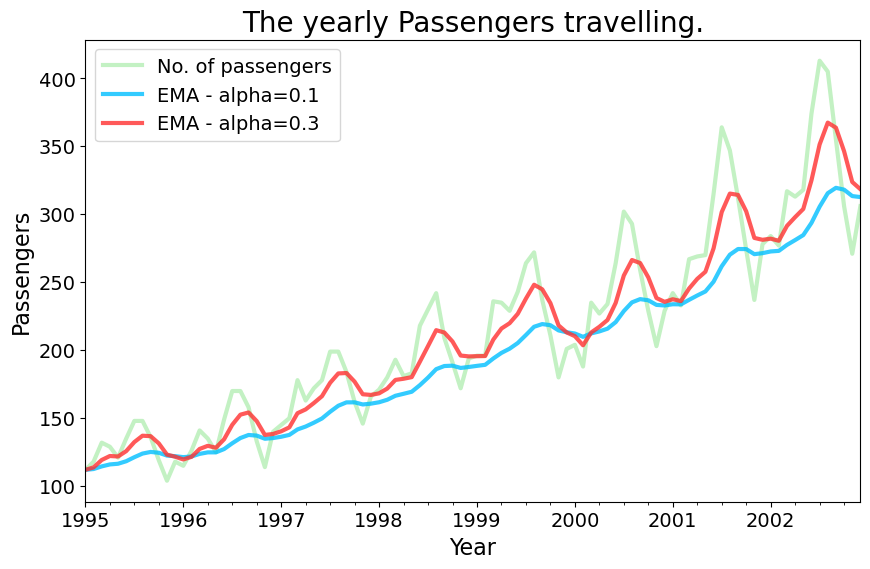

In [10]:
colors = ['#B4EEB4', '#00BFFF', '#FF3030']
airlines_data[['Passengers', 'Ema_0.1', 'Ema_0.3']].plot(color=colors, linewidth=3, figsize=(10,6), alpha=0.8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels=['No. of passengers', 'EMA - alpha=0.1', 'EMA - alpha=0.3'], fontsize=14)
plt.title('The yearly Passengers travelling.', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Passengers', fontsize=16);

## Time series decomposition plot

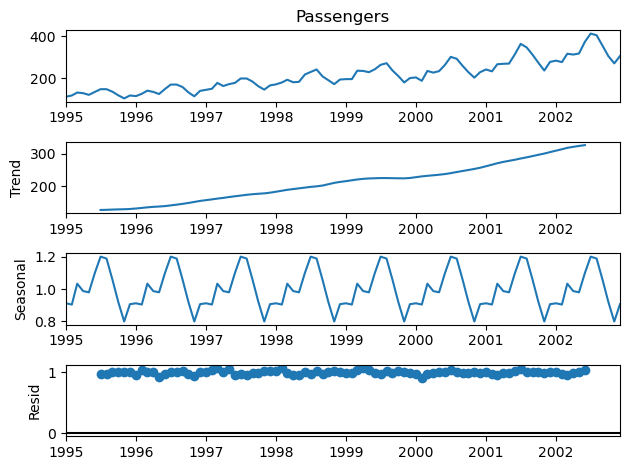

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_mul = seasonal_decompose(airlines_data.Passengers,model="multiplicative")
fig = ts_mul.plot()
plt.show();

## ACF plots and PACF plots

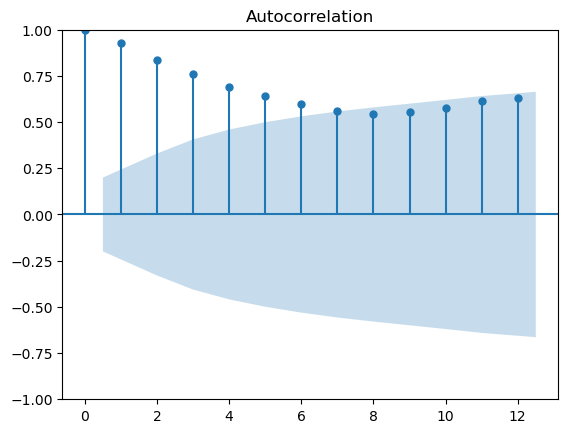

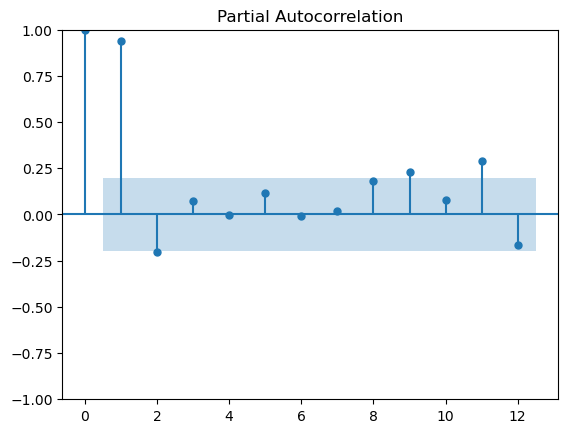

In [12]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(airlines_data.Passengers,lags=12)
tsa_plots.plot_pacf(airlines_data.Passengers,lags=12)
plt.show()


## Building Arima Model

In [13]:
X = airlines_data['Passengers']
size = int(len(X)*0.75)
size

72

In [14]:
train , test = X.iloc[0:size],X.iloc[size:len(X)]

In [15]:
train

Month
1995-01-01    112
1995-02-01    118
1995-03-01    132
1995-04-01    129
1995-05-01    121
             ... 
2000-08-01    293
2000-09-01    259
2000-10-01    229
2000-11-01    203
2000-12-01    229
Name: Passengers, Length: 72, dtype: int64

In [16]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(5,1,0))
model_fit=model.fit()

In [17]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                   72
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -305.554
Date:                Fri, 12 Jan 2024   AIC                            623.109
Time:                        14:48:32   BIC                            636.685
Sample:                    01-01-1995   HQIC                           628.508
                         - 12-01-2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1624      0.141      1.148      0.251      -0.115       0.440
ar.L2         -0.1854      0.146     -1.270      0.204      -0.471       0.101
ar.L3         -0.1191      0.111     -1.077      0.2

In [18]:
history = [x for x in train]
history[-1]

229

In [19]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

## Building and comparing multiple models

In [20]:
final_df = pd.read_excel("Airlines+Data.xlsx")
final_df['Date'] = pd.to_datetime(final_df.Month,format="%b-%y")
final_df['month'] = final_df.Date.dt.strftime("%b") #month extraction
final_df['year'] = final_df.Date.dt.strftime("%y")

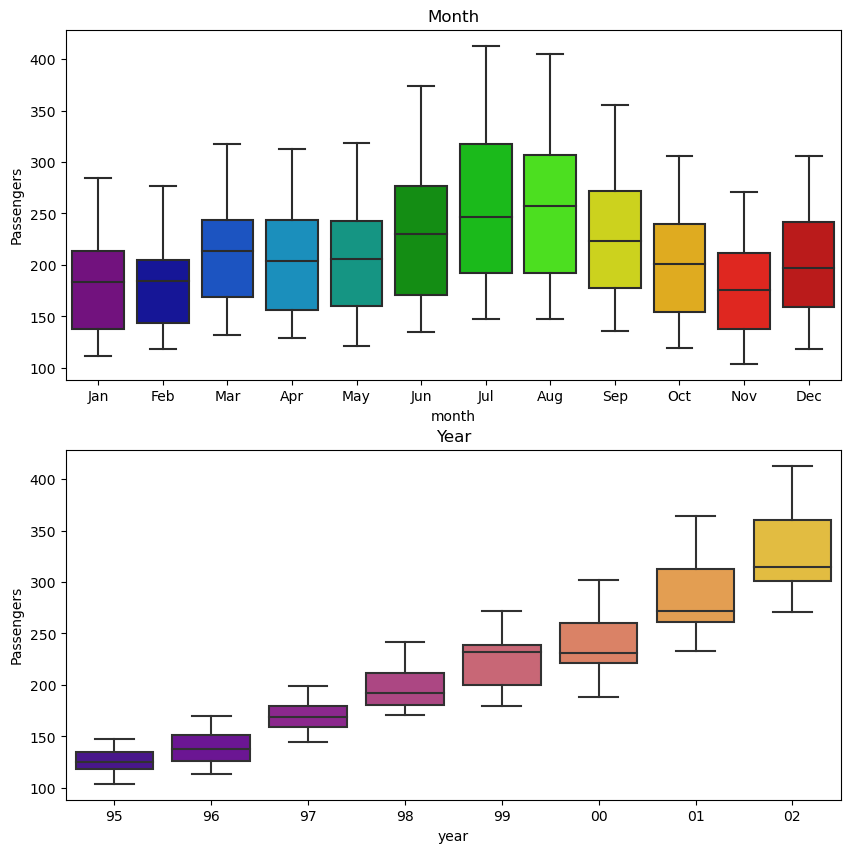

In [21]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Month')
sns.boxplot(x="month",y="Passengers",data=final_df,palette='nipy_spectral')
plt.subplot(212)
plt.title('Year')
sns.boxplot(x="year",y="Passengers",data=final_df,palette='plasma');

In [22]:
final_df = pd.get_dummies(final_df, columns = ['month'])

In [23]:
from typing_extensions import final
t= np.arange(1,97)
final_df['t']= t
final_df['t_square']= (t *t)
log_Passengers=np.log(final_df['Passengers'])
final_df['log_Passengers'] =log_Passengers
final_df

,Month,Passengers,Date,year,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,t,t_square,log_Passengers
0,1995-01-01,112,1995-01-01,95,0,0,0,0,1,0,0,0,0,0,0,0,1,1,4.718499
1,1995-02-01,118,1995-02-01,95,0,0,0,1,0,0,0,0,0,0,0,0,2,4,4.770685
2,1995-03-01,132,1995-03-01,95,0,0,0,0,0,0,0,1,0,0,0,0,3,9,4.882802
3,1995-04-01,129,1995-04-01,95,1,0,0,0,0,0,0,0,0,0,0,0,4,16,4.859812
4,1995-05-01,121,1995-05-01,95,0,0,0,0,0,0,0,0,1,0,0,0,5,25,4.795791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,2002-08-01,02,0,1,0,0,0,0,0,0,0,0,0,0,92,8464,6.003887
92,2002-09-01,355,2002-09-01,02,0,0,0,0,0,0,0,0,0,0,0,1,93,8649,5.872118
93,2002-10-01,306,2002-10-01,02,0,0,0,0,0,0,0,0,0,0,1,0,94,8836,5.723585
94,2002-11-01,271,2002-11-01,02,0,0,0,0,0,0,0,0,0,1,0,0,95,9025,5.602119


In [25]:
Train, Test = np.split(final_df, [int(.75 *len(final_df))])

In [26]:
#linear 

import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.6677929956463

In [27]:
#Exponential
Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['log_Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

297.3698089836234

In [28]:
#Quadratic
Quad = smf.ols('Passengers~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

51.990736401554834

In [29]:
add_sea = smf.ols('Passengers~month_Jan+month_Feb+month_Mar+month_Apr+month_May+month_Jun+month_Jul+month_Aug+month_Sep+month_Oct+month_Nov+month_Dec',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['month_Jan','month_Feb','month_Mar','month_Apr','month_May','month_Jun','month_Jul','month_Aug','month_Sep','month_Oct','month_Nov','month_Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

127.2645156532034

In [30]:
add_sea_Quad = smf.ols('Passengers~t+t_square+month_Jan+month_Feb+month_Mar+month_Apr+month_May+month_Jun+month_Jul+month_Aug+month_Sep+month_Oct+month_Nov+month_Dec',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['t','t_square','month_Jan','month_Feb','month_Mar','month_Apr','month_May','month_Jun','month_Jul','month_Aug','month_Sep','month_Oct','month_Nov','month_Dec']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.24160848593319

In [31]:
Mul_sea = smf.ols('log_Passengers~month_Jan+month_Feb+month_Mar+month_Apr+month_May+month_Jun+month_Jul+month_Aug+month_Sep+month_Oct+month_Nov+month_Dec',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test[['month_Jan','month_Feb','month_Mar','month_Apr','month_May','month_Jun','month_Jul','month_Aug','month_Sep','month_Oct','month_Nov','month_Dec']]))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['log_Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

173.46096019630755

In [32]:
Mul_Add_sea = smf.ols('log_Passengers~t+month_Jan+month_Feb+month_Mar+month_Apr+month_May+month_Jun+month_Jul+month_Aug+month_Sep+month_Oct+month_Nov+month_Dec',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test[['t','month_Jan','month_Feb','month_Mar','month_Apr','month_May','month_Jun','month_Jul','month_Aug','month_Sep','month_Oct','month_Nov','month_Dec']]))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['log_Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

303.3646933542652

In [36]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,rmse_add_sea_quad,35.241608
0,rmse_linear,51.667793
2,rmse_Quad,51.990736
3,rmse_add_sea,127.264516
5,rmse_Mult_sea,173.460960
1,rmse_Exp,297.369809
6,rmse_Mult_add_sea,303.364693


In [37]:
model_final = smf.ols('Passengers~t+t_square+month_Jan+month_Feb+month_Mar+month_Apr+month_May+month_Jun+month_Jul+month_Aug+month_Sep+month_Oct+month_Nov+month_Dec',data=Train).fit()
pred_new  = pd.Series(model_final.predict(Test))
pred_new

72    242.330988
73    244.902987
74    271.141653
75    263.713651
76    262.785650
77    283.357649
78    304.429648
79    306.334980
80    282.906979
81    259.978978
82    239.050977
83    260.622976
84    267.321927
85    269.914497
86    296.173733
87    288.766303
88    287.858873
89    308.451443
90    329.544013
91    331.469917
92    308.062487
93    285.155057
94    264.247627
95    285.840197
dtype: float64

In [40]:
predict_data= pd.DataFrame()
predict_data["forecasted_passengers"] = pd.Series(pred_new)
predict_data

,forecasted_passengers
72,242.330988
73,244.902987
74,271.141653
75,263.713651
76,262.785650
77,283.357649
78,304.429648
79,306.334980
80,282.906979
81,259.978978


In [39]:
visualize = pd.concat([Train,predict_data])
visualize

,Month,Passengers,Date,year,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,t,t_square,log_Passengers,forecasted_passengers
0,1995-01-01,112.0,1995-01-01,95,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.718499,NaN
1,1995-02-01,118.0,1995-02-01,95,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.770685,NaN
2,1995-03-01,132.0,1995-03-01,95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,9.0,4.882802,NaN
3,1995-04-01,129.0,1995-04-01,95,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,16.0,4.859812,NaN
4,1995-05-01,121.0,1995-05-01,95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,25.0,4.795791,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,331.469917
92,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,308.062487
93,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285.155057
94,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.247627


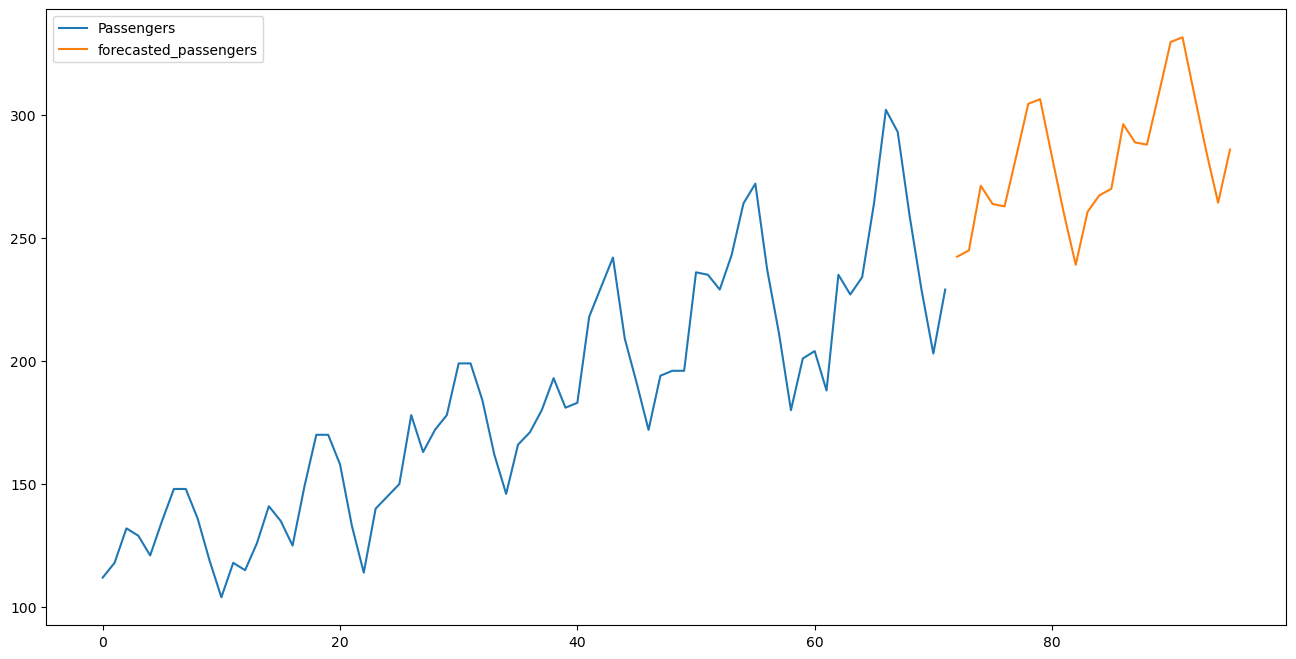

In [41]:
visualize[['Passengers','forecasted_passengers']].reset_index(drop=True).plot(figsize=(16,8));